In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
import ROOT
from numpy.random import normal
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


# Spectra with different voltages

In [3]:
bias = [63, 65, 67, 69, 71]

In [4]:
ds1120top = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Top {}V {} events loaded'.format(v, nev))
    ds1120top.append(dset)
    
ds1118top_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Top {}V {} events loaded'.format(v, nev))
    ds1118top_bkg.append(dset)

Top 63V 1003373 events loaded
Top 65V 1007528 events loaded
Top 67V 1016980 events loaded
Top 69V 1014919 events loaded
Top 71V 1015092 events loaded
Top 63V 217218 events loaded
Top 65V 217008 events loaded
Top 67V 218302 events loaded
Top 69V 217576 events loaded
Top 71V 216743 events loaded


## Baseline cut
Same baseline cut as calibration data (baseline std $<2.5$ ADC units). Cut fraction higher.

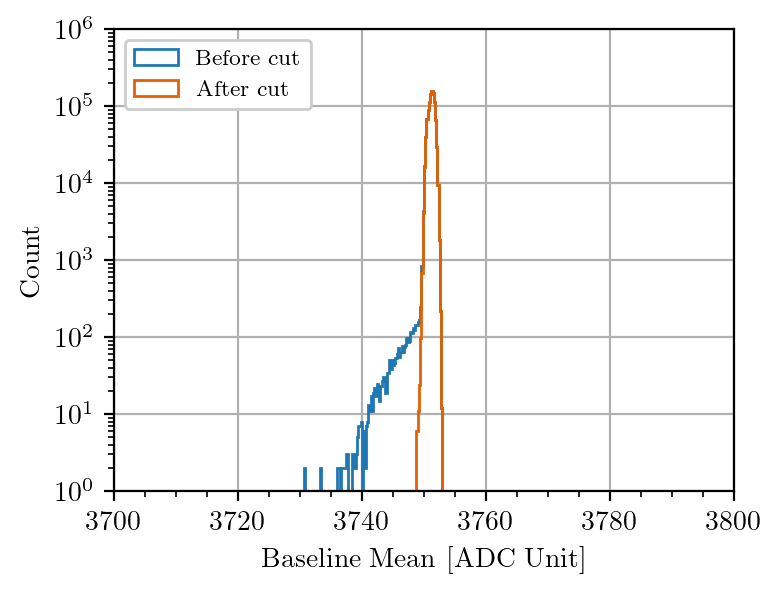

In [5]:
i=1
ch=0
dset = ds1120top[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

Text(0, 0.5, '$F_{\\rm prompt}$')

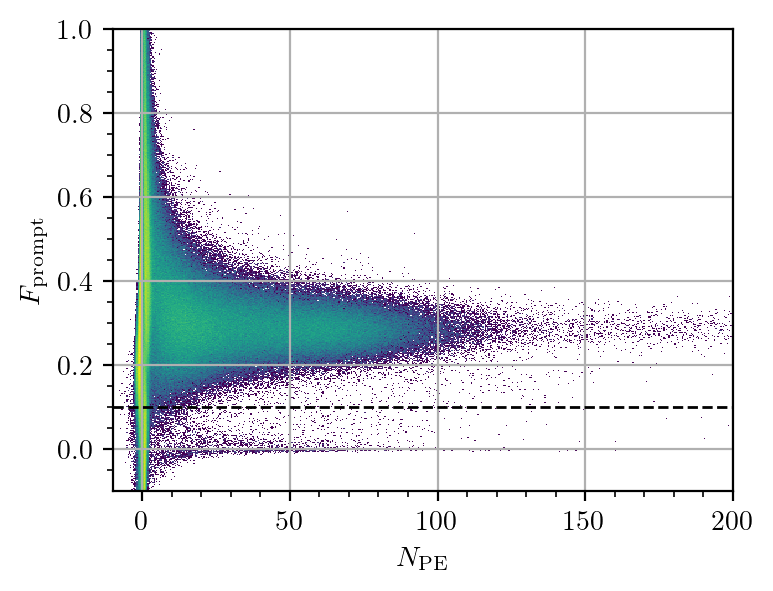

In [6]:
import matplotlib.colors as colors

i=1
dset = ds1120top[i]

nbinsx = 500
range_minx = -10
range_maxx = 200
nbinsy = 500
range_miny = -0.1
range_maxy = 1

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
# plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.minorticks_on()
plt.grid()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')


In [7]:
for i,v in enumerate(bias):
    dset = ds1120top[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118top_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm avg}/(1-p)}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

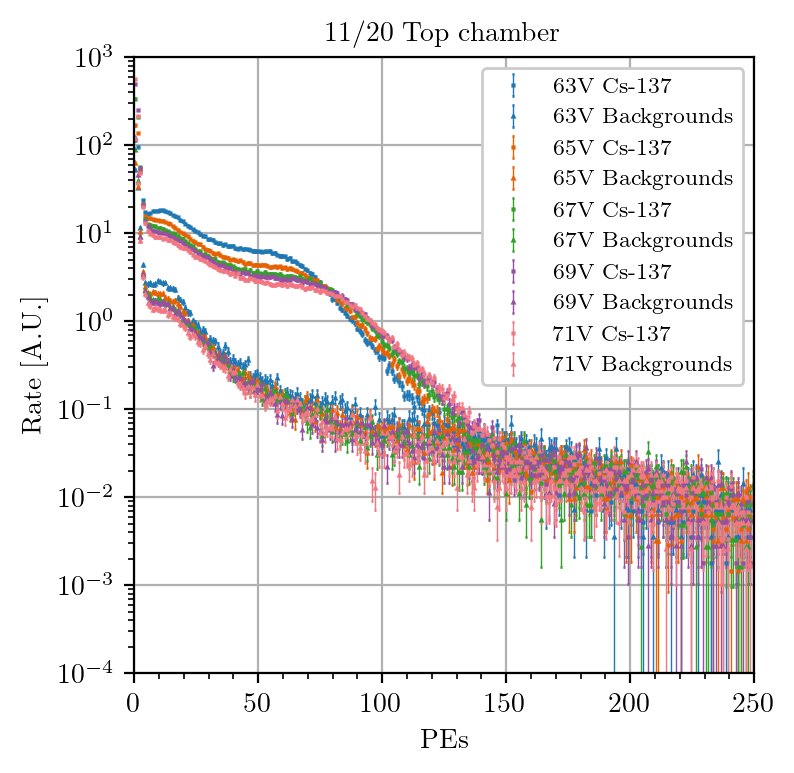

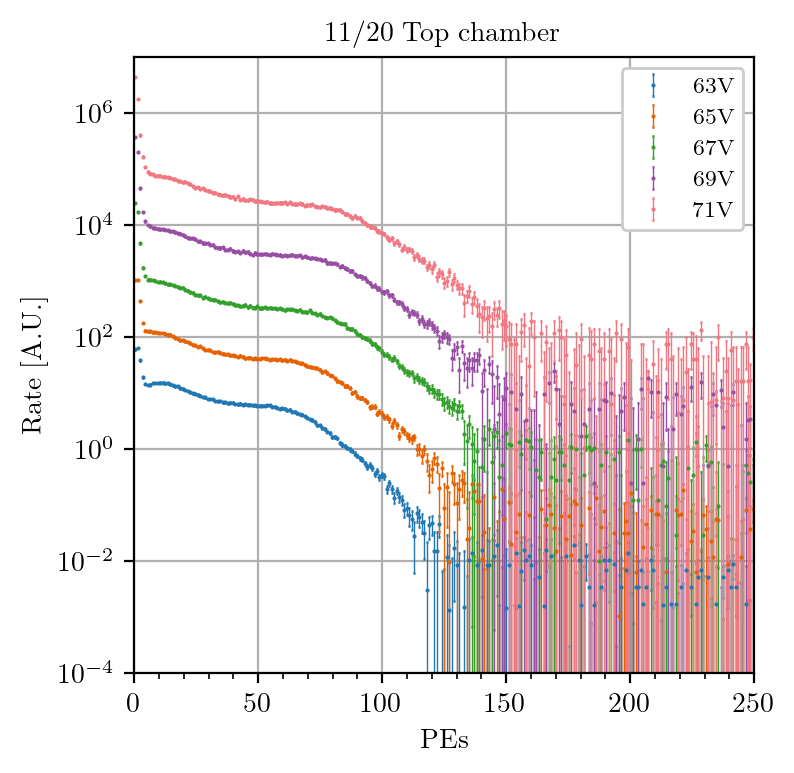

In [8]:
xmin = 0
xmax = 250
nbins = 250
bin_width = (xmax-xmin)/nbins

hist_gamma_top = []
hist_gamma_top_err = []
hist_gamma_top_bins = []
hist_bkg_top = []
hist_bkg_top_err = []
hist_bkg_top_bins = []
hist_dif_top = []
hist_dif_top_err = []
hist_dif_top_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [170, 170, 170, 170, 170]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120top)):
    hg,hgx = np.histogram(ds1120top[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hist_gamma_top_err.append(np.sqrt(hg))
    norm = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm
    hist_gamma_top_err[-1] = hist_gamma_top_err[-1]/norm
    hist_gamma_top.append(hg)
    hist_gamma_top_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_top_err[-1], label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}s'.format(i), markersize=0.5)

    hb,hbx = np.histogram(ds1118top_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hist_bkg_top_err.append(np.sqrt(hb))
    norm = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm
    hist_bkg_top_err[-1] = hist_bkg_top_err[-1]/norm
    hist_bkg_top.append(hb)
    hist_bkg_top_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_top_err[-1], label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}^'.format(i), markersize=0.5)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()


plt.figure(1,figsize=(4,4))
ymin = 1e-4
ymax = 1e7
hist_dif_top_bins = hist_gamma_top_bins
for i in range(len(hist_gamma_top)):
    hist_dif_top.append(hist_gamma_top[i]-hist_bkg_top[i])
    hist_dif_top_err.append(np.sqrt(hist_gamma_top_err[i]**2 + hist_bkg_top_err[i]**2))
    plt.errorbar(0.5*(hist_dif_top_bins[i][1:]+hist_dif_top_bins[i][:-1]), hist_dif_top[i]*10**i, yerr=hist_dif_top_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}o'.format(i), markersize=0.5)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid()
plt.minorticks_on()

# Bottom data 11/20

In [9]:
ds1120bot = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1120bot.append(dset)
    
ds1118bot_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1118bot_bkg.append(dset)

Bottom 63V 1014166 events loaded
Bottom 65V 1015363 events loaded
Bottom 67V 1015290 events loaded
Bottom 69V 1014591 events loaded
Bottom 71V 1015157 events loaded
Bottom 63V 216580 events loaded
Bottom 65V 216617 events loaded
Bottom 67V 217771 events loaded
Bottom 69V 217350 events loaded
Bottom 71V 218261 events loaded


# Baseline cut

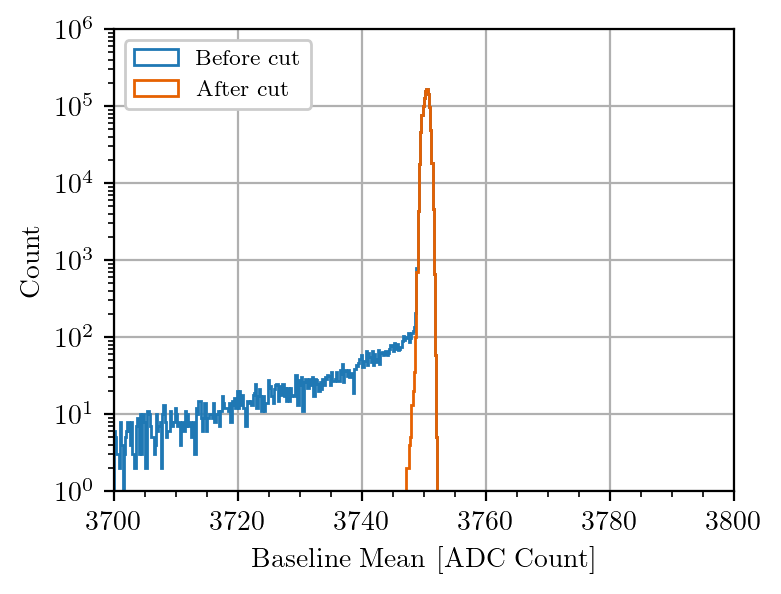

In [10]:
i=1
ch=0
dset = ds1120bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Count]')
plt.ylabel('Count')
plt.grid()
plt.minorticks_on()

# Fprompt cut

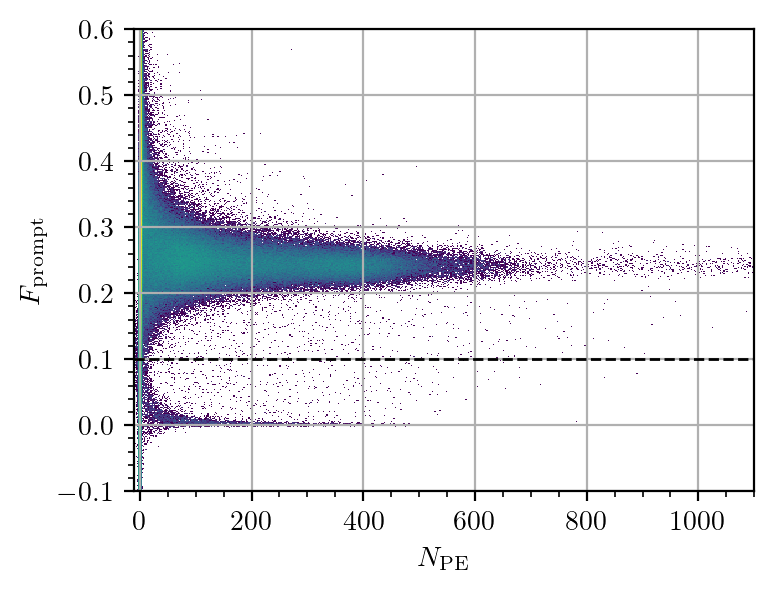

In [11]:
import matplotlib.colors as colors

i=1
dset = ds1120bot[i]

nbinsx = 500
range_minx = -10
range_maxx = 1100
nbinsy = 500
range_miny = -0.1
range_maxy = 0.6

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
# plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')
plt.grid()
plt.minorticks_on()

In [12]:
for i,v in enumerate(bias):
    dset = ds1120bot[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118bot_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

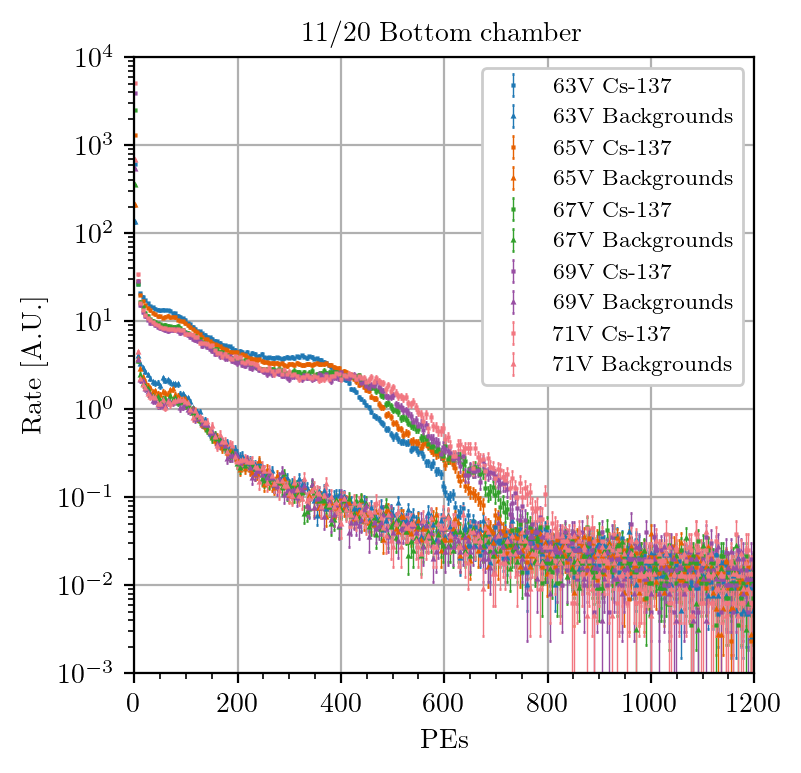

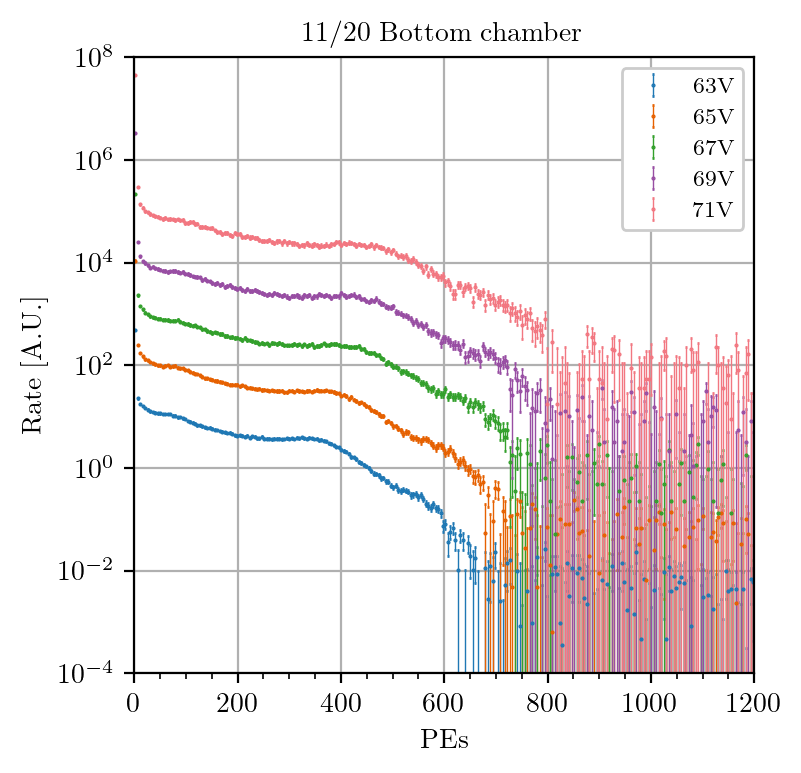

In [13]:
xmin = 0
xmax = 1200
nbins = 250
bin_width = (xmax-xmin)/nbins

hist_gamma_bot = []
hist_gamma_bot_err = []
hist_gamma_bot_bins = []
hist_bkg_bot = []
hist_bkg_bot_err = []
hist_bkg_bot_bins = []
hist_dif_bot = []
hist_dif_bot_err = []
hist_dif_bot_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [900, 900, 900, 900, 900]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120bot)):
    hg,hgx = np.histogram(ds1120bot[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hist_gamma_bot_err.append(np.sqrt(hg))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    norm = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm
    hist_gamma_bot_err[i] = hist_gamma_bot_err[i]/norm
    hist_gamma_bot.append(hg)
    hist_gamma_bot_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_bot_err[-1], label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}s'.format(i), markersize=0.5)

    hb,hbx = np.histogram(ds1118bot_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hist_bkg_bot_err.append(np.sqrt(hb))
    norm = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm
    hist_bkg_bot_err[i] = hist_bkg_bot_err[i]/norm
    hist_bkg_bot.append(hb)
    hist_bkg_bot_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_bot_err[-1], label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}^'.format(i), markersize=0.5)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()


plt.figure(1,figsize=(4,4))
hist_dif_bot_bins = hist_gamma_bot_bins
for i in range(len(hist_gamma_bot)):
    hist_dif_bot.append(hist_gamma_bot[i]-hist_bkg_bot[i])
    hist_dif_bot_err.append(np.sqrt(hist_gamma_bot_err[i]**2 + hist_bkg_bot_err[i]**2))
    plt.errorbar(0.5*(hist_dif_bot_bins[i][1:]+hist_dif_bot_bins[i][:-1]), hist_dif_bot[i]*10**i, yerr=hist_dif_bot_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}o'.format(i), markersize=0.5)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()

## Read DiCT probability from csv file

In [2]:
import csv
p_dict_top = []
p_dict_bot = []
for i,volt in enumerate(bias):
    with open('calibration_1122_{}V.csv'.format(volt)) as f:
        r = csv.reader(f)
        p_top = 0
        p_bot = 0
        line_count = 0
        for row in r:
            if line_count>0:
                if line_count<=4:
                    p_top += float(row[3])
                else:
                    p_bot += float(row[3])
            line_count += 1
        p_top /= 4
        p_bot /= 4
        p_dict_top.append(p_top)
        p_dict_bot.append(p_bot)
print(p_dict_top)
print(p_dict_bot)

NameError: name 'bias' is not defined

## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [15]:
def chisquare_two_hist_new(ly, alpha, data_hist, data_hist_bins, data_hist_err, tree, p_dict, range_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
#     print(np.shape(data_hist), np.shape(data_hist_bins), np.shape(data_hist_err))
    
    simulated_pe = []
    for i,ev in enumerate(tree):
        lyr = normal(ly, ly*alpha)
        simulated_pe.append(normal(lyr*ev.Edep, np.sqrt((1+p_dict)*lyr*ev.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hSimPE_err = np.sqrt(hSimPE)
#     print(np.shape(hSimPE), np.shape(hSimPE_bins), np.shape(hSimPE_err))
    simulated_pe = []
    range_bin = [int((range_pe[0]-xmin)/bin_width), int((range_pe[1]-xmin)/bin_width)]
    norm_sim = np.sum(data_hist[range_bin[0]:range_bin[1]])/np.sum(hSimPE[range_bin[0]:range_bin[1]])
    hSimPE = hSimPE*norm_sim
    hSimPE_err = hSimPE_err*norm_sim
    chi_square = 0
    for i in range(range_bin[0], range_bin[1]):
        chi_square += (data_hist[i] - hSimPE[i])**2/((data_hist_err[i])**2 + (hSimPE_err[i])**2)
    dof = range_bin[1]-range_bin[0] - 4
    print(ly, alpha, chi_square, dof)
    return chi_square

# Chi-square map
Light yield $L_y$ and non-uniformity $\alpha$ are the fit parameters.
The simulated spectrum is generated for each ($L_y$,$\alpha$) combination.
The $\chi^2$ maps have statistical noises, so it is impossible to fit using a minimizer.
Instead, we fit the $\chi^2$ maps with $-2\ln\mathcal{L}$, where $\mathcal{L}$ is bivariate Gaussian distribution.
The best-fit parameters and the covariance matrix are obtained from $\mathcal{L}$
For interval estimation, 68% CL in 2D corresponds to 1.515 $\sigma$.

In [14]:
from scipy.stats import multivariate_normal

def gauss2d(xy, ly, fano, Sx, Sy, theta, c):
    sxx = Sx**2*np.cos(theta)**2+Sy**2*np.sin(theta)**2
    sxy = (Sx**2-Sy**2)*np.sin(theta)*np.cos(theta)
    syy = Sx**2*np.sin(theta)**2+Sy**2*np.cos(theta)**2
    return -2*np.log(2*np.pi*Sx*Sy*multivariate_normal(mean=[ly,fano], cov=[[sxx, sxy],[sxy, syy]]).pdf(xy))+c

## Top

0.16 0.01 266.3261979792045 96
0.16077777777777777 0.01 200.23323081628195 96
0.16155555555555556 0.01 170.35436028272554 96
0.16233333333333333 0.01 144.7595373490359 96
0.16311111111111112 0.01 149.99999157018925 96
0.1638888888888889 0.01 121.26969247236212 96
0.16466666666666668 0.01 105.59380167265984 96
0.16544444444444445 0.01 95.81060486674674 96
0.16622222222222224 0.01 128.01319479887857 96
0.167 0.01 153.75238003902948 96
0.16 0.022222222222222223 232.361464064989 96
0.16077777777777777 0.022222222222222223 211.25911750995164 96
0.16155555555555556 0.022222222222222223 170.58535531838334 96
0.16233333333333333 0.022222222222222223 159.9088306149079 96
0.16311111111111112 0.022222222222222223 113.17769018953973 96
0.1638888888888889 0.022222222222222223 111.19508813324838 96
0.16466666666666668 0.022222222222222223 103.24977462711273 96
0.16544444444444445 0.022222222222222223 140.2276321619529 96
0.16622222222222224 0.022222222222222223 121.9374369320943 96
0.167 0.022222222

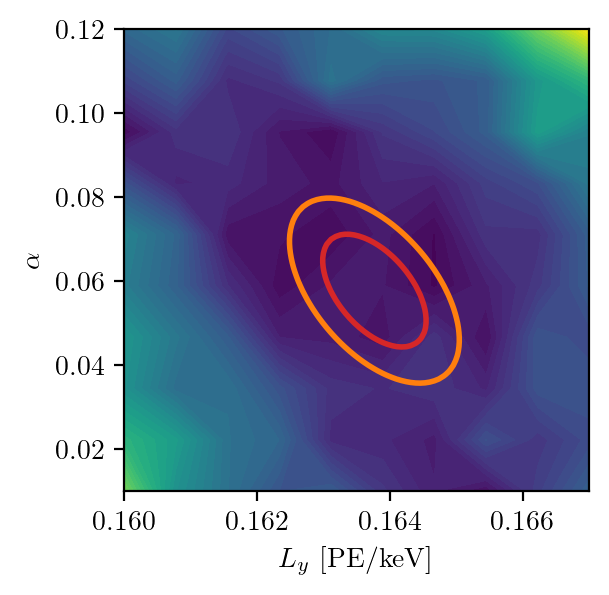

In [20]:
from scipy.stats import norm

# TOP CHAMBER
data_hist = hist_dif_top[2]
data_hist_bins = hist_dif_top_bins[2]
data_hist_err = hist_dif_top_err[2]
p_dict = p_dict_top[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")
# file.Close()

# (Ly,F) range
lys = np.linspace(0.160, 0.167, 10)
alphas = np.linspace(0.01, 0.12, 10)
X,Y = np.meshgrid(lys, alphas)
XX,YY = np.meshgrid(np.linspace(lys[0],lys[-1],100),np.linspace(alphas[0],alphas[-1],100))

# fig,(ax1,ax2)=plt.subplots(1,2)
# fig.set_size_inches(18,9)
plt.figure(0,figsize=(3,3))

# Spectrum fit range
norm_min = 50
norm_max = 150
chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict, [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])
plt.contourf(X,Y,chi2map,50)
# cp=ax1.contourf(X, Y, chi2map, 50)
# fig.colorbar(cp) # Add a colorbar to a plot
file.Close()

# Fit chi-square to find minimum and errors
popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[0.164, 0.06, 0.0005, 0.008, 0.04, 88], maxfev=10000)
print(*popt)
plt.contour(XX,YY,gauss2d(np.dstack((XX,YY)),*popt),[popt[5]-2*np.log(2*(1-norm.cdf(1,0,1))), popt[5]-2*np.log(2*(1-norm.cdf(2,0,1)))], colors=['tab:red', 'tab:orange'])
# cp=ax2.contourf(X, Y, gauss2d(np.dstack((X,Y)),*popt), 50)
# fig.colorbar(cp)
plt.xlabel(r'$L_y$ [PE/keV]')
plt.ylabel(r'$\alpha$')

# Print best fit values and 68% CL
ly_fit = popt[0]
alpha_fit = popt[1]
ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
alpha_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))

174324 events simulated


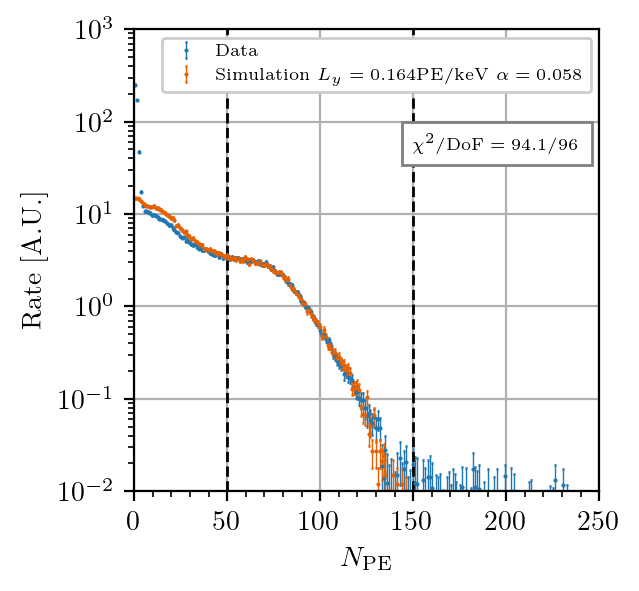

In [21]:
# TOP CHAMBER
data_hist = hist_dif_top[2]
data_hist_bins = hist_dif_top_bins[2]
data_hist_err = hist_dif_top_err[2]
p_dict = p_dict_top[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

simPE = []
nev = 0
for i,ev in enumerate(tr):
    ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
    simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict)*ly_random*tr.Edep)))
    nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
xmin = data_hist_bins[0]
xmax = data_hist_bins[-1]
nbins = len(data_hist_bins)-1
bin_width = (xmax-xmin)/nbins
hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
hSimErr = np.sqrt(hSim)
norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
hSim = hSim*norm
hSimErr = hSimErr*norm

plt.figure(0,figsize=(3,3))
plt.rcParams.update({'font.size': 8})
plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha={:.3f}$'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.text(150, 5e1, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4), fontsize=6, bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right',fontsize=6)
# plt.title('11/20 Top chamber 67V')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
file.Close()

Running for top 63V
0.137 0.01 244.13893293182298 96
0.1376666666666667 0.01 208.60237229647842 96
0.13833333333333334 0.01 164.16846498616985 96
0.139 0.01 151.11314688720933 96
0.1396666666666667 0.01 108.35548789382251 96
0.14033333333333334 0.01 109.73844864627576 96
0.14100000000000001 0.01 114.69821832153711 96
0.1416666666666667 0.01 117.47587008591269 96
0.14233333333333334 0.01 117.36487183818123 96
0.14300000000000002 0.01 133.44223054701317 96
0.137 0.022222222222222223 270.13682115014996 96
0.1376666666666667 0.022222222222222223 211.9690804043248 96
0.13833333333333334 0.022222222222222223 181.8005915373536 96
0.139 0.022222222222222223 165.09003472846408 96
0.1396666666666667 0.022222222222222223 117.43643969524904 96
0.14033333333333334 0.022222222222222223 111.29782957209133 96
0.14100000000000001 0.022222222222222223 113.74800641347682 96
0.1416666666666667 0.022222222222222223 92.79421801197995 96
0.14233333333333334 0.022222222222222223 102.2991055085742 96
0.1430000

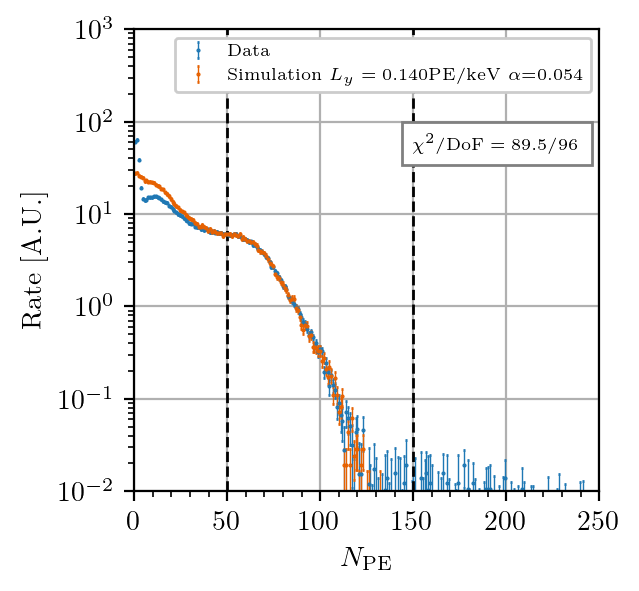

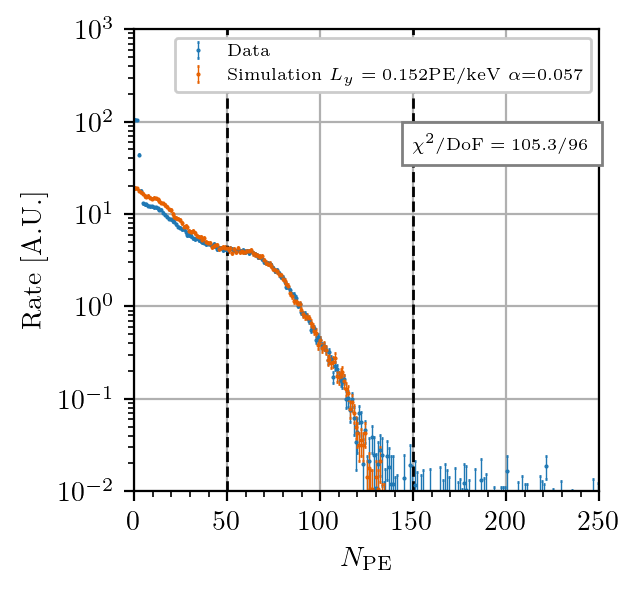

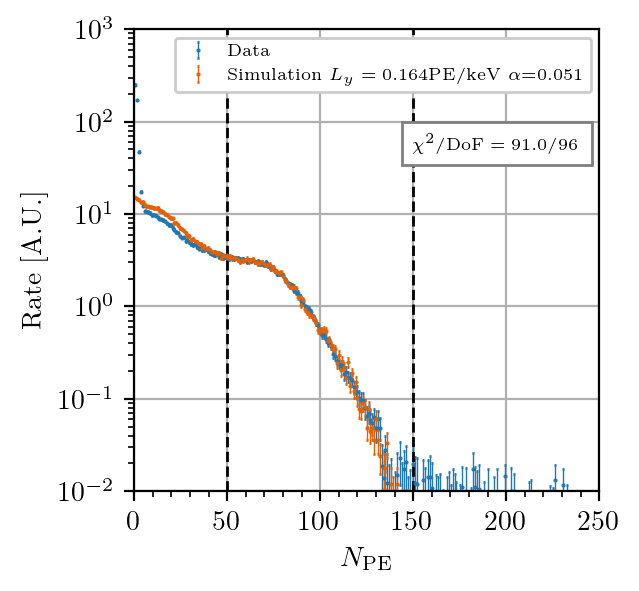

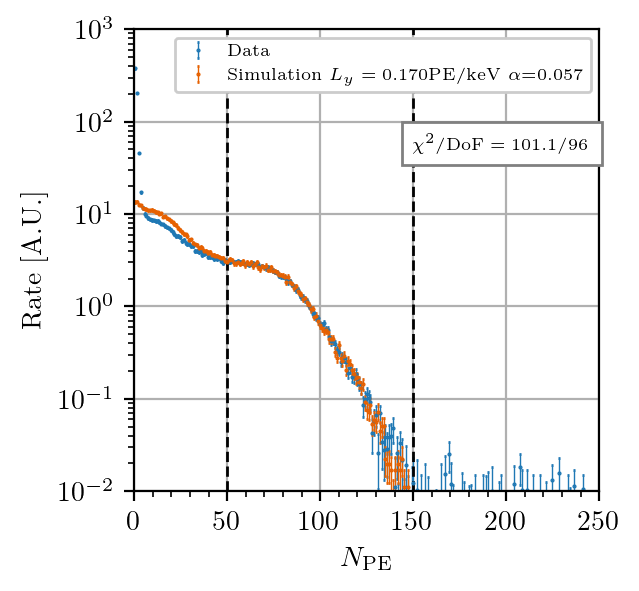

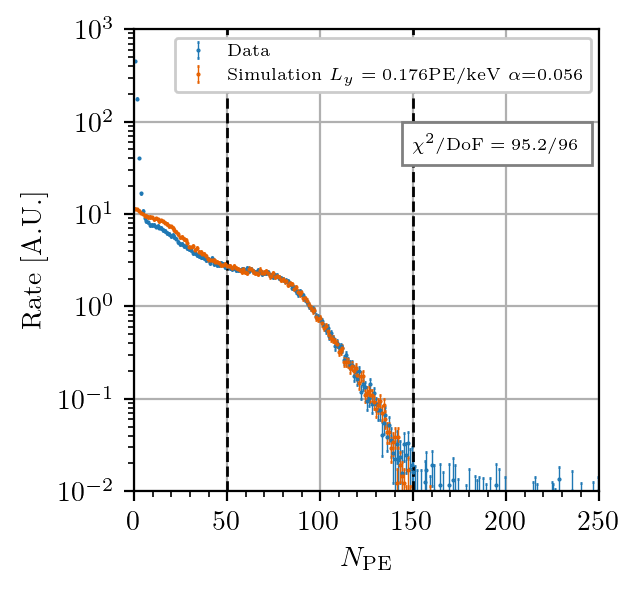

In [22]:
ly_guess = [0.140, 0.152, 0.163, 0.168, 0.176]
ly_top = []
alpha_top = []
for iv,volt in enumerate(bias):
    print('Running for top {}V'.format(volt))
    data_hist = hist_dif_top[iv]
    data_hist_bins = hist_dif_top_bins[iv]
    data_hist_err = hist_dif_top_err[iv]

    file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]-0.003, ly_guess[iv]+0.003, 10)
    alphas = np.linspace(0.01, 0.12, 10)
    X,Y = np.meshgrid(lys, alphas)

    # Spectrum fit range
    norm_min = 50
    norm_max = 150
    chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict_top[iv], [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 0.06, 0.0005, 0.008, 0.04, 88], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    alpha_fit = popt[1]
    ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    alpha_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
    ly_top.append([ly_fit, ly_68])
    alpha_top.append([alpha_fit, alpha_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
            simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict_top[iv])*ly_random*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e3
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm
    hSimErr = hSimErr*norm
    plt.figure(iv,figsize=(3,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(150, 5e1, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4), fontsize=6, bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
    plt.grid()
    plt.minorticks_on()
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right', fontsize=6)
    # plt.title('11/20 Top chamber {}V'.format(volt))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Text(0.5, 0.98, 'Top')

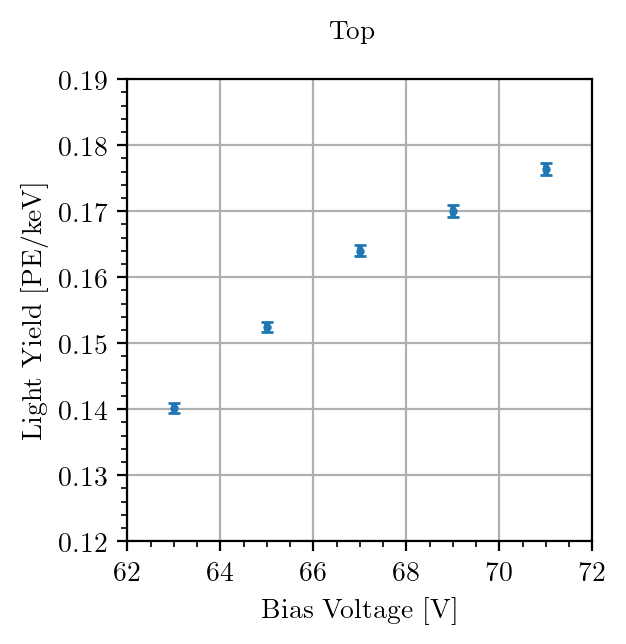

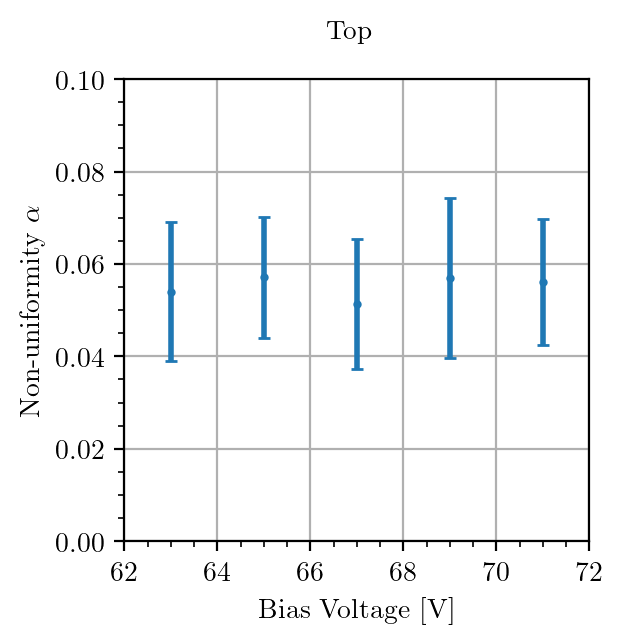

In [23]:
plt.figure(0,figsize=(3,3))
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=np.array(ly_top)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Light Yield [PE/keV]')
plt.xlim(62,72)
plt.ylim(0.12,0.19)
plt.suptitle('Top')

plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_top)[:,0],yerr=np.array(alpha_top)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.xlim(62,72)
plt.ylim(0,0.1)
plt.suptitle('Top')

## Bottom

0.93 0.01 453.51330656052966 121
0.9344444444444445 0.01 416.16749829446076 121
0.9388888888888889 0.01 360.6909272855995 121
0.9433333333333334 0.01 367.1407798630558 121
0.9477777777777778 0.01 309.05627711640574 121
0.9522222222222222 0.01 288.2413846347668 121
0.9566666666666667 0.01 300.78331409193925 121
0.9611111111111111 0.01 286.4413582937488 121
0.9655555555555555 0.01 309.60514884579834 121
0.97 0.01 309.63621158195104 121
0.93 0.022222222222222223 416.37231245129203 121
0.9344444444444445 0.022222222222222223 336.7559764160965 121
0.9388888888888889 0.022222222222222223 318.93952723786083 121
0.9433333333333334 0.022222222222222223 279.13583736980246 121
0.9477777777777778 0.022222222222222223 254.32524431326038 121
0.9522222222222222 0.022222222222222223 264.1431367387943 121
0.9566666666666667 0.022222222222222223 262.1357645207463 121
0.9611111111111111 0.022222222222222223 259.96418694267834 121
0.9655555555555555 0.022222222222222223 281.13182577332356 121
0.97 0.02222

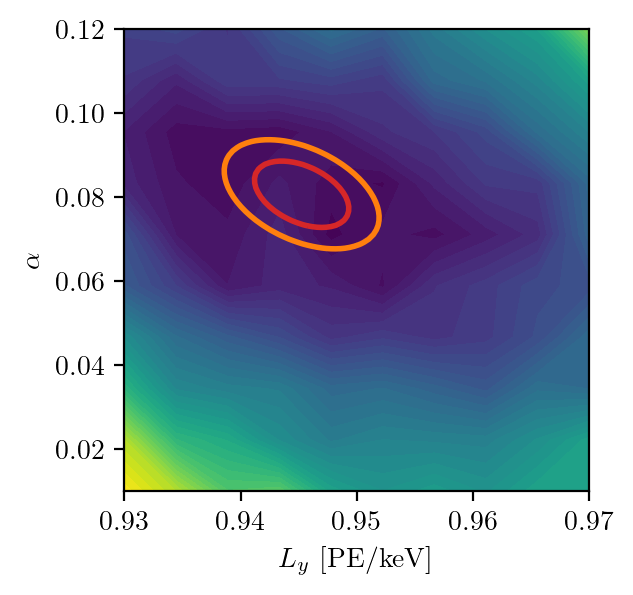

In [24]:
from scipy.stats import norm

# TOP CHAMBER
data_hist = hist_dif_bot[2]
data_hist_bins = hist_dif_bot_bins[2]
data_hist_err = hist_dif_bot_err[2]
p_dict = p_dict_bot[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")
# file.Close()

# (Ly,F) range
lys = np.linspace(0.93, 0.97, 10)
alphas = np.linspace(0.01, 0.12, 10)
X,Y = np.meshgrid(lys, alphas)
XX,YY = np.meshgrid(np.linspace(lys[0],lys[-1],100),np.linspace(alphas[0],alphas[-1],100))

# fig,(ax1,ax2)=plt.subplots(1,2)
# fig.set_size_inches(18,9)
plt.figure(0,figsize=(3,3))

# Spectrum fit range
norm_min = 300
norm_max = 900
chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict, [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])
plt.contourf(X,Y,chi2map,50)
# cp=ax1.contourf(X, Y, chi2map, 50)
# fig.colorbar(cp) # Add a colorbar to a plot
file.Close()

# Fit chi-square to find minimum and errors
popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[0.95, 0.07, 0.002, 0.005, 0.2, 140], maxfev=10000)
print(*popt)
plt.contour(XX,YY,gauss2d(np.dstack((XX,YY)),*popt),[popt[5]-2*np.log(2*(1-norm.cdf(1,0,1))), popt[5]-2*np.log(2*(1-norm.cdf(2,0,1)))], colors=['tab:red', 'tab:orange'])
# cp=ax2.contourf(X, Y, gauss2d(np.dstack((X,Y)),*popt), 50)
# fig.colorbar(cp)
plt.xlabel(r'$L_y$ [PE/keV]')
plt.ylabel(r'$\alpha$')

# Print best fit values and 68% CL
ly_fit = popt[0]
alpha_fit = popt[1]
ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
alpha_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))

174324 events simulated


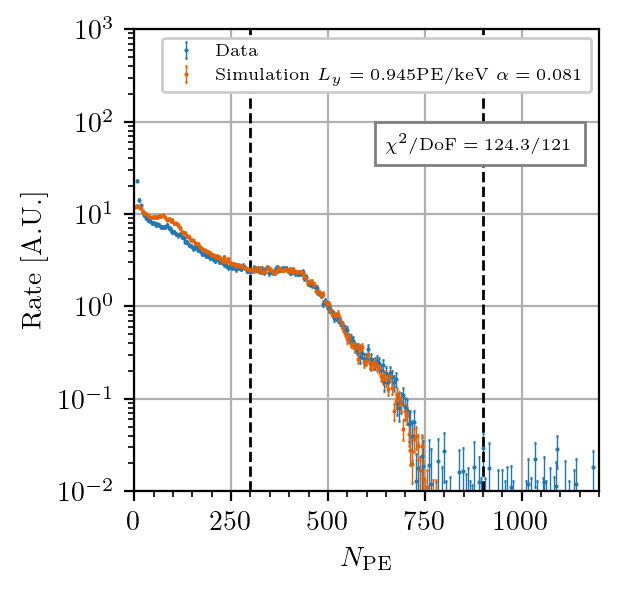

In [25]:
data_hist = hist_dif_bot[2]
data_hist_bins = hist_dif_bot_bins[2]
data_hist_err = hist_dif_bot_err[2]
p_dict = p_dict_bot[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

simPE = []
nev = 0
for i,ev in enumerate(tr):
    ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
    simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict)*ly_random*tr.Edep)))
    nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
xmin = data_hist_bins[0]
xmax = data_hist_bins[-1]
nbins = len(data_hist_bins)-1
bin_width = (xmax-xmin)/nbins
hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
hSimErr = np.sqrt(hSim)
norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
hSim = hSim*norm
hSimErr = hSimErr*norm

plt.figure(0,figsize=(3,3))
plt.rcParams.update({'font.size': 8})
plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha={:.3f}$'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.text(650, 5e1, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4), fontsize=6,bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right',fontsize=6)
# plt.title('11/20 Top chamber 67V')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
file.Close()

Running for bottom 63V
0.79 0.01 708.7526584087755 121
0.7944444444444445 0.01 704.90585820251 121
0.798888888888889 0.01 615.4735153890176 121
0.8033333333333333 0.01 486.6454072216458 121
0.8077777777777778 0.01 508.2567767634129 121
0.8122222222222223 0.01 436.2056318588096 121
0.8166666666666668 0.01 420.5966068250596 121
0.8211111111111111 0.01 441.3639232725697 121
0.8255555555555556 0.01 425.5248124930127 121
0.8300000000000001 0.01 494.6099914293047 121
0.79 0.022222222222222223 672.1505316958675 121
0.7944444444444445 0.022222222222222223 568.5526183640611 121
0.798888888888889 0.022222222222222223 522.6646230185227 121
0.8033333333333333 0.022222222222222223 445.4841431165105 121
0.8077777777777778 0.022222222222222223 412.7365257856778 121
0.8122222222222223 0.022222222222222223 363.682525053356 121
0.8166666666666668 0.022222222222222223 365.69960320693116 121
0.8211111111111111 0.022222222222222223 384.1026061588791 121
0.8255555555555556 0.022222222222222223 380.409794077

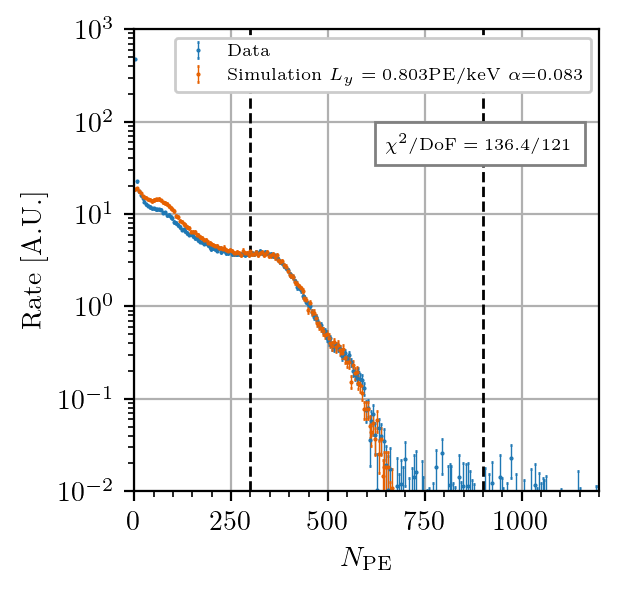

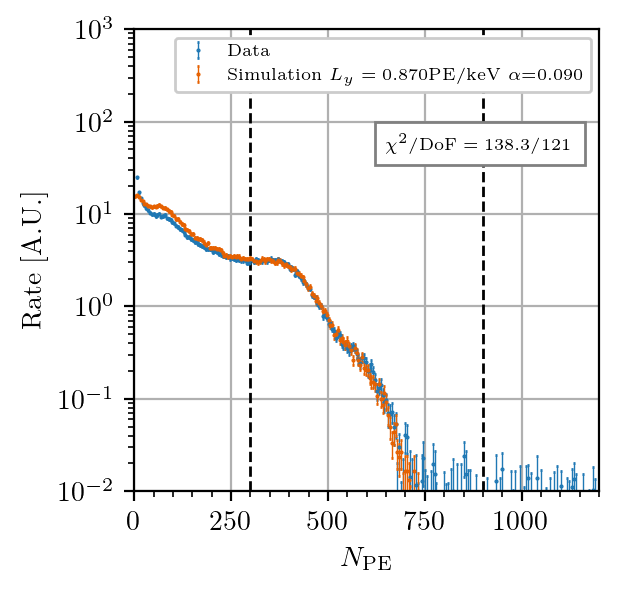

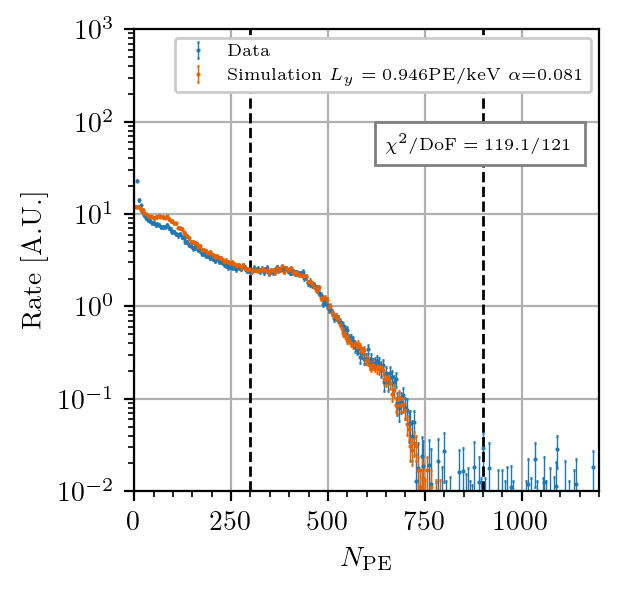

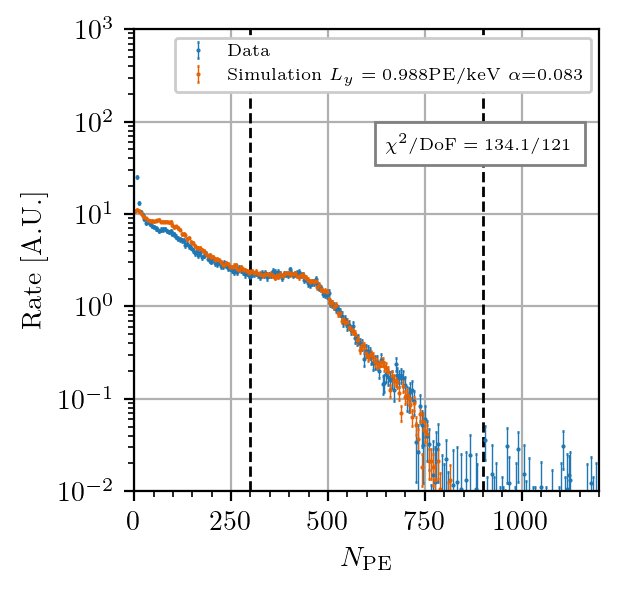

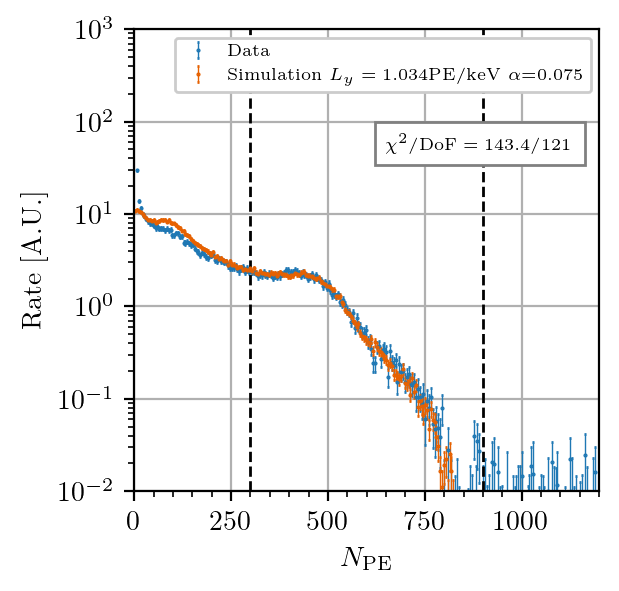

In [26]:
ly_guess = [0.81, 0.87, 0.95, 0.99, 1.04]
ly_bot = []
alpha_bot = []
for iv,volt in enumerate(bias):
    print('Running for bottom {}V'.format(volt))
    data_hist = hist_dif_bot[iv]
    data_hist_bins = hist_dif_bot_bins[iv]
    data_hist_err = hist_dif_bot_err[iv]

    file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]-0.02, ly_guess[iv]+0.02, 10)
    alphas = np.linspace(0.01, 0.12, 10)
    X,Y = np.meshgrid(lys, alphas)

    # Spectrum fit range
    norm_min = 300
    norm_max = 900
    chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict_bot[iv], [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 0.08, 0.002, 0.006, 0.2, 150], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    alpha_fit = popt[1]
    ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    alpha_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
    ly_bot.append([ly_fit, ly_68])
    alpha_bot.append([alpha_fit, alpha_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
            simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict_bot[iv])*ly_random*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e3
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm
    hSimErr = hSimErr*norm
    plt.figure(iv,figsize=(3,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(650, 5e1, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4), fontsize=6,bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
    plt.grid()
    plt.minorticks_on()
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right', fontsize=6)
    # plt.title('11/20 Top chamber {}V'.format(volt))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Text(0.5, 0.98, 'Bottom')

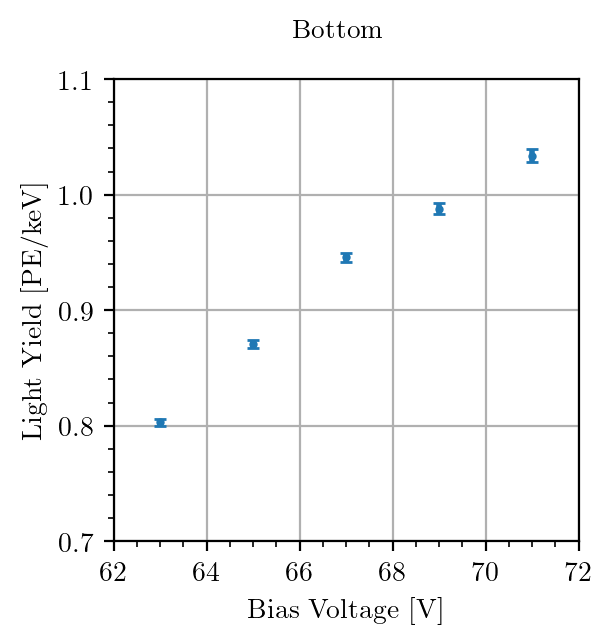

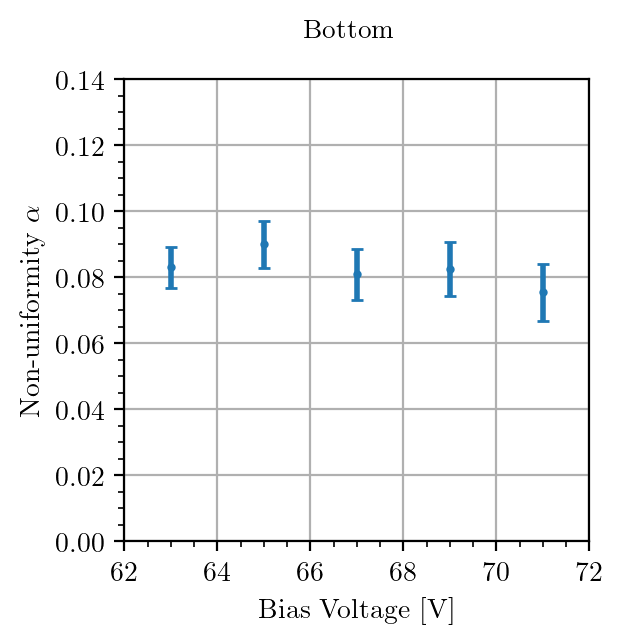

In [27]:
plt.figure(0,figsize=(3,3))
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=np.array(ly_bot)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Light Yield [PE/keV]')
plt.xlim(62,72)
plt.ylim(0.7,1.1)
plt.suptitle('Bottom')

plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_bot)[:,0],yerr=np.array(alpha_bot)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.xlim(62,72)
plt.ylim(0,0.14)
plt.suptitle('Bottom')

## Top-Bottom Comparison

Average Tyvek-to-ESR Ly ratio = 0.1734+/-0.0005


(0.0, 0.14)

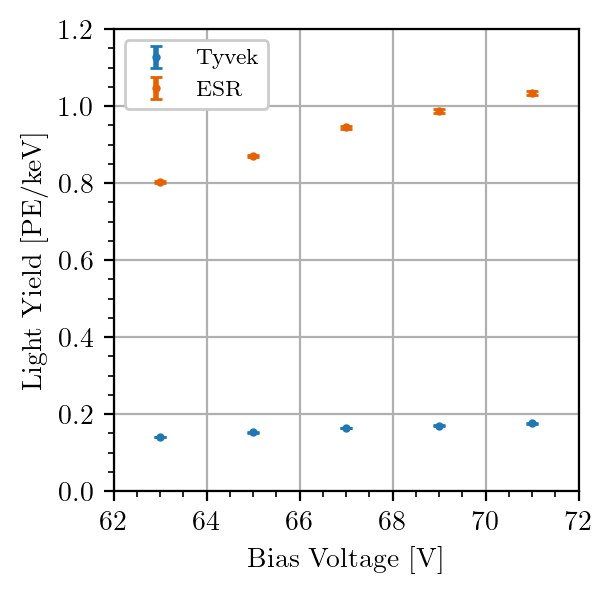

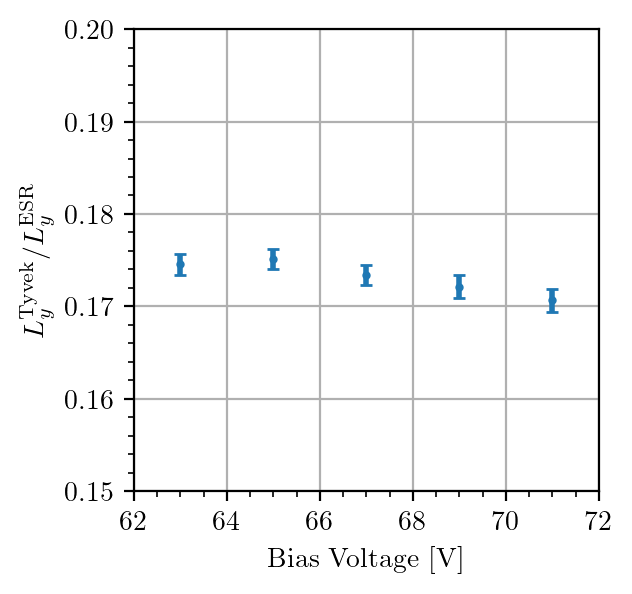

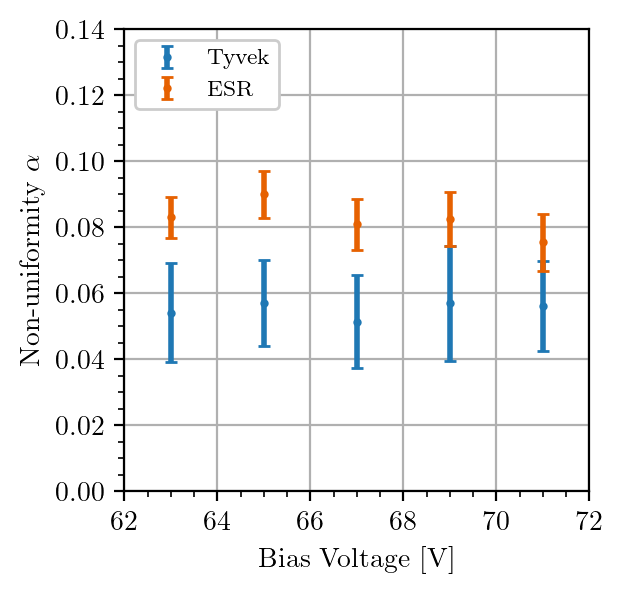

In [32]:
plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=np.array(ly_top)[:,1], fmt='o', label='Tyvek', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=np.array(ly_bot)[:,1], fmt='o', label='ESR', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,1.2)

plt.figure(2,figsize=(3,3))
ly_ratio = np.array(ly_top)[:,0]/np.array(ly_bot)[:,0]
ly_ratio_err = ly_ratio * np.sqrt((np.array(ly_bot)[:,1]/np.array(ly_bot)[:,0])**2+(np.array(ly_top)[:,1]/np.array(ly_top)[:,0])**2)
plt.errorbar(bias,ly_ratio,yerr=ly_ratio_err, fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)

lyr_mu = np.sum(ly_ratio/ly_ratio_err**2)/np.sum(1/ly_ratio_err**2)
lyr_sigma = 1/np.sqrt(np.sum(1/ly_ratio_err**2))
print('Average Tyvek-to-ESR Ly ratio = {:.4f}+/-{:.4f}'.format(lyr_mu, lyr_sigma))

plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0.15,0.20)

plt.figure(3,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_top)[:,0],yerr=np.array(alpha_top)[:,1], fmt='o', label='Tyvek', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.errorbar(bias,np.array(alpha_bot)[:,0],yerr=np.array(alpha_bot)[:,1], fmt='o', label='ESR', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,0.14)

# Coincidence settings

In [92]:
# Coincidence table
#      high trg rate <---------> low trg rate
# c0-3 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA

# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [93]:
file_coinc = [  'gamma_1117_65V_top_OOO',
                'gamma_1117_65V_top_AOO',
                'gamma_1117_65V_top_OOA',
                'gamma_1117_65V_top_AAO',
                'gamma_1117_65V_top_OAA',
                'gamma_1115_65V_top_AAA',]
coinc = ['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']

In [94]:
ds1117top = []
for i,f in enumerate(file_coinc):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/{}.root".format(f), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            # dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut and ev.f_prompt>0.1:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            nev += 1
            
    print('Top 65V {} {} events loaded'.format(coinc[i], nev))
    ds1117top.append(dset)

Top 65V OOO 752328 events loaded


KeyboardInterrupt: 

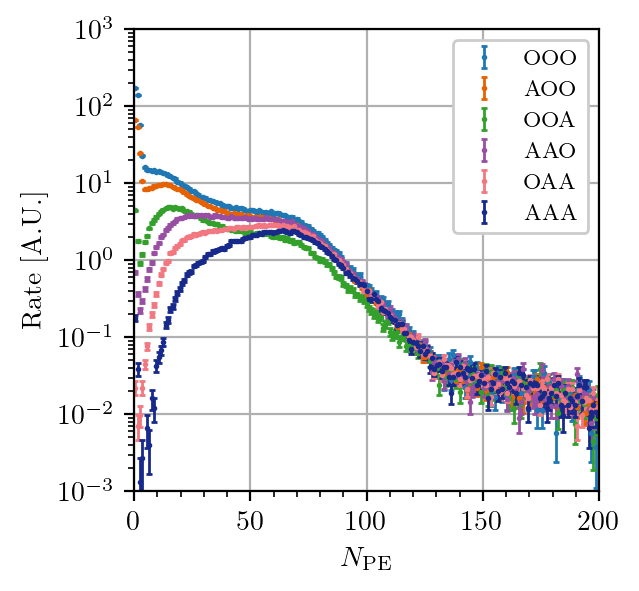

In [ ]:
xmin = 0
xmax = 200
nbins = 200
bin_width = (xmax-xmin)/nbins

hist = []
hist_err = []
hist_bins = []
plt.figure(0,figsize=(3,3))
for i,dset in enumerate(ds1117top):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    herr = np.sqrt(h)
    norm = np.sum(h[int((150-xmin)/bin_width):])
    h = h/norm
    herr = herr/norm
    hist.append(h)
    hist_err.append(herr)
    hist_bins.append(hx)
    plt.errorbar(0.5*(hx[1:]+hx[:-1]), h, yerr=herr, label=coinc[i], fmt='o', ls='none', elinewidth=1, markersize=1, capsize=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
# plt.title('11/17 Top chamber 65V coincidence levels')
plt.xlim(xmin, xmax)
plt.ylim(1e-3,1e3)
plt.minorticks_on()
plt.grid()